In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import h5py
import glob
import itertools
from ast import literal_eval
from scipy.interpolate import interp1d

def roc_params_build(rocx, rocy, ftype):
    output = {}
    bound_sup = 4
    bound_inf = -4
    basis = np.linspace(bound_inf, bound_sup, 70)
    for i in range(0, rocx.shape[1]):
        xt = interp1d(rocx[:,i], basis, fill_value = 'extrapolate')
        yt = interp1d(rocy[:,i],basis, fill_value = 'extrapolate')
        tx = interp1d(basis,rocx[:,i], fill_value = 'extrapolate')
        ty = interp1d(basis,rocy[:,i], fill_value = 'extrapolate')
        xy = interp1d(rocx[:,i], rocy[:,i], fill_value = 'extrapolate')
        yx = interp1d(rocy[:,i], rocx[:,i], fill_value = 'extrapolate')
        output[ftype[i]] = [[xt,tx],[yt,ty],[xy,yx]]
   
    return output

def bug_array_fix(df, column):
    df_out = df[column]
    df_out = df_out.str.replace('\n',',').str.replace('  ',',').str.replace('[','').str.replace(']','').str.replace(' ',',').str.split(',')
    return df_out.apply(lambda x: (np.array(x)[np.array(x)!='']).astype(np.float))

def get_roc_params(dfx,dfy, sg_eff = 0.99):
    roc_x = np.array(np.matrix(dfx.tolist()))
    roc_y = np.array(np.matrix(dfy.tolist()))
    auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
    bg_fix = []
    for i in range(0,roc_x.shape[0]):
        x = np.array(roc_x[i,:])
        y = np.array(roc_y[i,:])
        f = interp1d(x,y,fill_value = 'extrapolate')
        bg_fix.append(f(sg_eff))
    return auc, bg_fix, roc_y[:,index]


def roc_params(dfx, dfy, thresholds):
  bound_sup = 4
  bound_inf = -4
  basis = np.linspace(bound_inf, bound_sup, 70)
  roc_x = np.array(np.matrix(dfx.tolist()))
  roc_y = np.array(np.matrix(dfy.tolist()))
  auc = abs(np.diff(np.array(roc_x))*np.array(roc_y)[:,:-1]).sum(axis = 1)
  signal_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  bg_eff = np.zeros((roc_x.shape[0], len(thresholds)))
  roc_point = np.zeros((roc_x.shape[0], len(thresholds)))
  for (n, t) in list(enumerate(thresholds)):
    for i in range(0,roc_x.shape[0]):
      x = np.array(roc_x[i,:])
      y = np.array(roc_y[i,:])
      fx = interp1d(basis, x, fill_value = 'extrapolate')
      fy = interp1d(basis, y, fill_value = 'extrapolate')
      fxy = interp1d(x, y, fill_value = 'extrapolate')
      signal_eff[i, n] = fx(t)
      bg_eff[i, n] = fy(t)
      roc_point[i, n] = fxy(t)
   
  return auc, signal_eff, bg_eff, roc_point 



def scatter(df_filt, key_analysis, labels, title):
    import matplotlib
    #key_analysis = ['Intensity mean','delta_bg_eff_1_cumulative']
    fig = plt.figure(figsize=(12,8))
    x           = df_filt[key_analysis[0]]
    y           = df_filt[key_analysis[1]]
    label_name  = df_filt.ftype

    ## enconding labels
    from sklearn import preprocessing
    le          = preprocessing.LabelEncoder()
    le.fit(label_name)
    label       = le.transform(label_name)

    ## selecionando cores para plot de forma randomica
    np.random.seed(10)
    colors = np.random.rand(len(np.unique(label)),3)

    ## scatter plots pelas cores de cada classe (w)
    plt.scatter(x, 100*y, c=label, alpha=0.3,cmap=matplotlib.colors.ListedColormap(colors))

    ## ajustes do plot e barra de exibicao
    plt.xlabel(labels[0],fontsize = 14)
    plt.ylabel(labels[1],fontsize = 12)
    plt.title(title)
    plt.grid()
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc+0.25)
    ## criando labels na colorbar
    ticklabels = []
    for i in np.unique(label_name):
        ticklabels.append(i)

    cb.set_ticklabels(ticklabels)

In [2]:
df = pd.read_csv('../data/result_5.csv')
df.head(1)

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated
0,-55.833883,1.0,2539.0,561.0,wierner,1.0,[1. 1. 1. 1. 1...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,[2.60119056e+07 2.60119056e+07 2.60119056e+07 ...


In [3]:
df['ROCx'] = bug_array_fix(df,'ROCx')
df['ROCy'] = bug_array_fix(df,'ROCy')

In [4]:
t_values    = [.5,1.,1.5]
new_sg_columns = ['sg_eff_'+str(i) for i in t_values]
new_bg_columns = ['bg_eff_'+str(i) for i in t_values] 
auc,sg,bg,_ = roc_params(df['ROCx'], df['ROCy'],[1,1.5,2])
efficiency_df = pd.DataFrame(np.append(sg,bg,axis = 1), columns=new_sg_columns+new_bg_columns)
df = pd.concat([df,efficiency_df],axis = 1)

/home/renatel/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/renatel/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [5]:
index = list(range(0,100))
n_size = df.shape[0]//100
indexes = n_size*index
df['image_num'] = indexes
df.head(3)

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,image_num
0,-55.833883,1.0,2539.0,561.0,wierner,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[2.60119056e+07 2.60119056e+07 2.60119056e+07 ...,0.000000,0.0,0.0,0.999861,1.0,1.0,0
1,-54.941974,1.0,1683.0,677.0,wierner,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[2.60088814e+07 2.60088814e+07 2.60088814e+07 ...,0.000000,0.0,0.0,0.999858,1.0,1.0,1
2,-51.341407,1.0,4110.0,925.0,wierner,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[2.60109443e+07 2.60109443e+07 2.60109443e+07 ...,0.000946,0.0,0.0,0.999874,1.0,1.0,2


In [6]:
deltas = ['delta_' + st for st in list(efficiency_df.columns) + ['SNR']]
cumulatives = [i + '_cumulative' for i in deltas]
columns = list(df.columns) + deltas + cumulatives
dfObj = pd.DataFrame(columns=columns)
dfObj

,SNR,w_size,Energy,Area,filter,window,ROCx,ROCy,Energy Estimated,sg_eff_0.5,...,delta_bg_eff_1.0,delta_bg_eff_1.5,delta_SNR,delta_sg_eff_0.5_cumulative,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5_cumulative,delta_bg_eff_0.5_cumulative,delta_bg_eff_1.0_cumulative,delta_bg_eff_1.5_cumulative,delta_SNR_cumulative


In [7]:
values = list(df.groupby(by=['image_num','filter']))
data = pd.DataFrame([],columns = values[0][1].columns)

In [8]:
#data = dict((k,[]) for k in deltas+cumulatives)
#data = pd.DataFrame([],columns = aux.columns)
for i in range(0,len(values)):
    aux = values[i][1]
    for key1,key2 in zip(deltas, cumulatives):
        diff = np.pad(np.diff(aux[key1.split('delta_')[1]]),(1,0),'constant')
        diff_cum = diff.cumsum()
        #data[key1] = np.append(data[key1],diff)
        #data[key2] = np.append(data[key2],diff_cum)
        aux[key1] = diff
        aux[key2] = diff_cum
        #data.columns = aux.columns
    data = data.append(aux)
    #aux = aux[aux.columns]    
    #dfObj = pd.concat([dfObj,aux],axis = 0)    
#dfObj.head(3)        

/home/renatel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
df = data
df['Intensity mean'] = df['Energy']/df['Area']

In [10]:
## filtrando dados para visualizacao
filtro = ['mean','gauss']   ## somente filtros listados
window = [1,3,5,7]              ## somente nestas janelas

df_filt    = df[df.window.isin(window)]
pattern    = '|'.join(filtro)
df_filt    = df_filt[df_filt['filter'].str.contains(pattern)]
new_column = df_filt['filter']  + ', window = ' + df_filt['window'].astype('str') 
df_filt.drop(['filter','window'],axis = 1,inplace = True)
df_filt['ftype']  = new_column
df_filt.head(3)

,Area,Energy,Energy Estimated,ROCx,ROCy,SNR,bg_eff_0.5,bg_eff_1.0,bg_eff_1.5,delta_SNR,...,delta_sg_eff_1.0_cumulative,delta_sg_eff_1.5,delta_sg_eff_1.5_cumulative,image_num,sg_eff_0.5,sg_eff_1.0,sg_eff_1.5,w_size,Intensity mean,ftype
100,561.0,2539.0,[25995018.59074217 25993497.3838523 25991125....,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.000672826598, 0.000737815531, 0.00083721036...",-58.244543,0.785472,0.891431,0.950832,0.000000,...,0.000000,0.000000,0.000000,0,0.695187,0.568182,0.451426,1.0,4.525847,"gauss, window = 1.0"
400,561.0,2539.0,[2.59679701e+07 2.59662873e+07 2.59649060e+07 ...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00169354, 0.00175852, 0.00181204, 0.0018961...",-44.448274,0.931679,0.981147,0.993949,13.796269,...,-0.009470,-0.043672,-0.043672,0,0.702540,0.558712,0.407754,3.0,4.525847,"gauss, window = 3.0"
700,561.0,2539.0,[2.59721104e+07 2.59705256e+07 2.59690491e+07 ...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.00153297, 0.00159414, 0.00165148, 0.0017164...",-39.102234,0.973538,0.995806,0.999244,5.346040,...,-0.064283,-0.060160,-0.103832,0,0.700312,0.503899,0.347594,5.0,4.525847,"gauss, window = 5.0"


## Rejeição de background 1.5 sigma

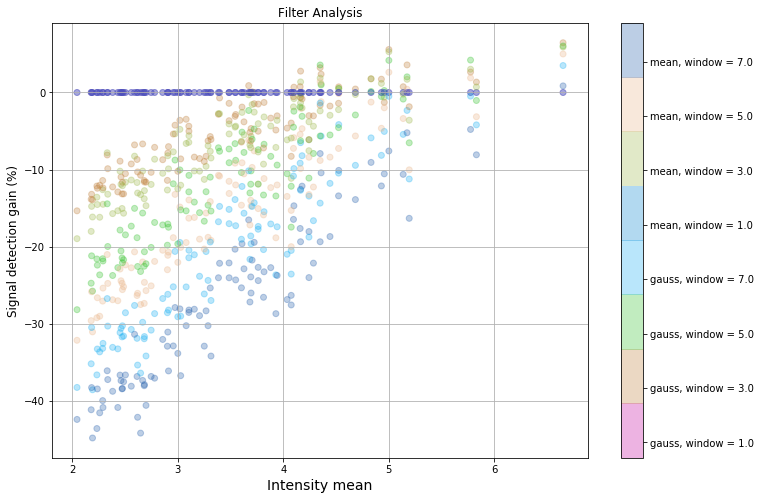

In [11]:
scatter(df_filt, 
        ['Intensity mean','delta_sg_eff_0.5_cumulative'],
        ['Intensity mean','Signal detection gain (%)'], 
        'Filter Analysis')

## Construindo a ROC média e std

In [244]:
#df_filt
filters = df_filt['ftype'].unique()
mean_sg = np.zeros((df_filt['ROCx'].iloc[0].shape[0],
                    filters.shape[0]))
std_sg = np.zeros_like(mean_sg)
mean_bg = np.zeros_like(mean_sg)
std_bg = np.zeros_like(mean_sg)
for i,f in list(enumerate(filters)):
    aux = df_filt[df_filt['ftype'] == f]
    roc_x = np.array(aux['ROCx'].tolist())
    roc_y = np.array(aux['ROCy'].tolist())
    if(len(roc_x.shape) > 2):
        roc_x = roc_x[:,:,0]
    mean_sg[:,i] = roc_x.mean(axis=0)
    std_sg[:,i] = roc_x.std(axis = 0)
    mean_bg[:,i] = roc_y.mean(axis=0)
    std_bg[:,i] = roc_y.std(axis=0)

## Plot das ROC's para sinal fixo -> melhoria no numero de pixels de background (tempo de processamento)

Text(0, 0.5, 'Background rejection efficiency')

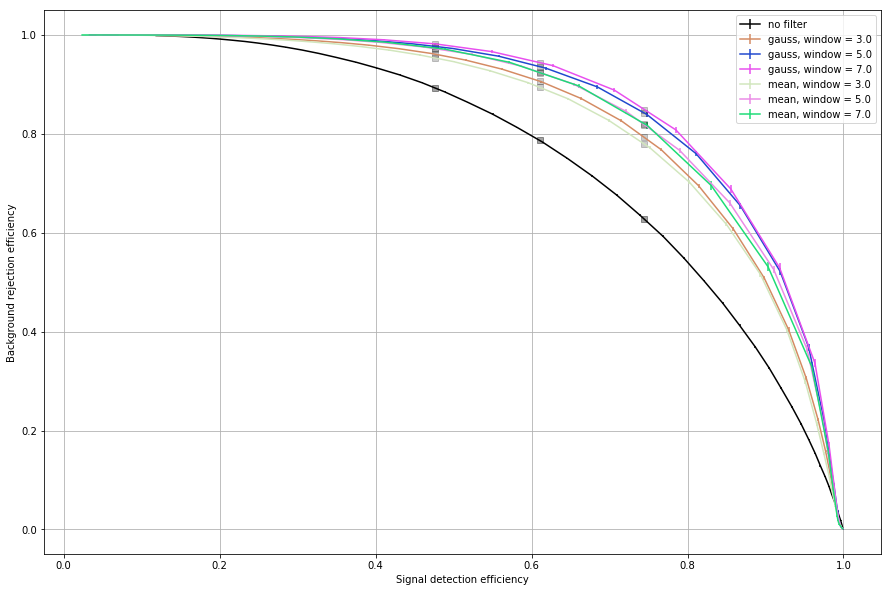

In [260]:
np.random.seed(5)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_signal_values = objects[filters[0]][0][1](thr_points)
base_background_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_background_values.append(objects[f][2][0](base_signal_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_background_values = np.array(base_background_values).ravel()   
base_signal_values = np.tile(base_signal_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)   
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)

#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--b', label = 'threshold = 1.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_0.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--r', label = 'threshold = 0.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.0'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--g', label = 'threshold = 1.0 sigma')
    
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')

In [256]:
n_bg_pixels = (1-base_background_values.reshape(-1,3))*((512*512)-df['Area'].mean())

### Número de pixels de background

In [265]:
print((n_bg_pixels).astype(np.int))

[[97390 55719 27956]
 [54194 24416 10134]
 [41300 16734  6044]
 [39421 14595  4696]
 [97390 55719 27956]
 [57669 27673 12135]
 [47426 19799  7243]
 [46946 19875  6865]]


## Plot das ROC's para o background fixo -> mostrar na estimação de energia

Text(0, 0.5, 'Background rejection efficiency')

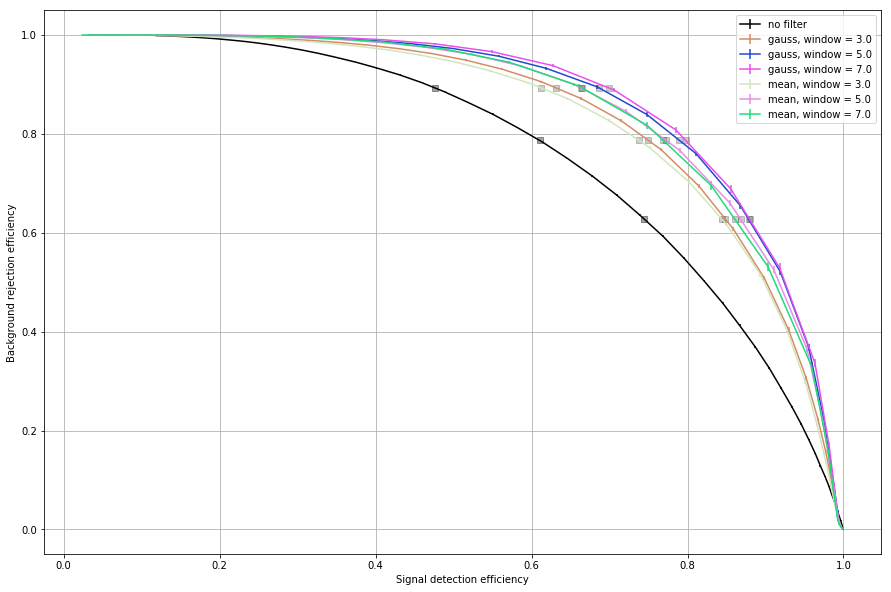

In [273]:
np.random.seed(5)
thr_points = [0.5,1,1.5]
new_thr_values = []
objects = roc_params_build(mean_sg,mean_bg,filters)
base_background_values = objects[filters[0]][1][1](thr_points)
base_signal_values = []
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    base_signal_values.append(objects[f][2][1](base_background_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(mean_sg[:,i],
                        mean_bg[:,i],
                        2*std_bg[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(mean_sg[:,i],
                    mean_bg[:,i],
                    2*std_bg[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 
base_signal_values = np.array(base_signal_values).ravel()   
base_background_values = np.tile(base_background_values,len(filters))
ax.plot(base_signal_values,base_background_values,'sk',alpha = 0.2)
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)   
#plt.plot(impx_points,impy_points,'ko',alpha = 0.4)

#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--b', label = 'threshold = 1.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_0.5'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--r', label = 'threshold = 0.5 sigma')
#thr = df_filt[df_filt['ftype']=='mean, window = 1.0']['sg_eff_1.0'].mean()
#plt.plot(thr*np.ones((70,)),mean_bg[:,0],'--g', label = 'threshold = 1.0 sigma')
    
plt.legend()
plt.grid()
plt.xlabel('Signal detection efficiency')
plt.ylabel('Background rejection efficiency')

## Construindo as curvas de energia

In [287]:
#df_filt
#df_filt['Energy Estimated'] = bug_array_fix(df_filt,'Energy Estimated')
df_filt['Energy Error'] = df_filt['Energy']-df_filt['Energy Estimated'] 
filters = df_filt['ftype'].unique()
mean_energy = np.zeros((df_filt['Energy Error'].iloc[0].shape[0],
                        filters.shape[0]))
std_energy = np.zeros_like(mean_energy)
for i,f in list(enumerate(filters)):
    aux = df_filt[df_filt['ftype'] == f]
    energy = np.array(aux['Energy Error'].tolist())
    if(len(roc_x.shape) > 2):
        energy = roc_x[:,:,0]
    mean_energy[:,i] = energy.mean(axis=0)
    std_energy[:,i] = energy.std(axis = 0)

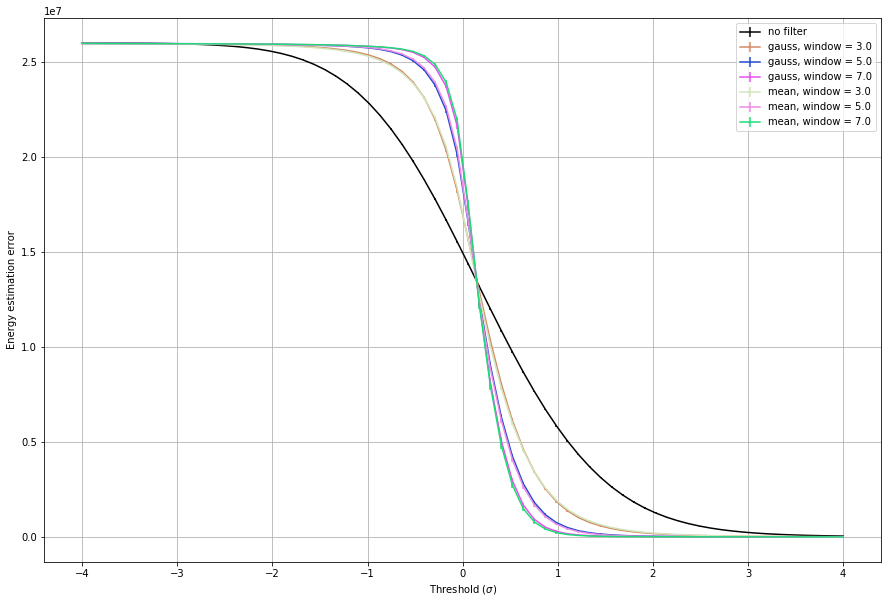

In [318]:
np.random.seed(5)
bound_sup = 4
bound_inf = -4
basis = np.linspace(bound_inf, bound_sup, 70)
fig,ax = plt.subplots(1,1, figsize=(15,10))
flag = 0
for i,f in list(enumerate(filters)):
    #base_signal_values.append(objects[f][2][1](base_background_values))
    if (sum(df_filt[df_filt['w_size'] == 1.0]['ftype'] == filters[i]) != 0):
        color = 'black'
        label = 'no filter'
        flag+=1
        if flag<=1:
            ax.errorbar(basis,
                        abs(mean_energy[:,i]),
                        2*std_energy[:,i],
                        linestyle = '-',
                        label = label,
                        color = color) 
            
    else:
        color = '#%06X' % np.random.randint(0, 0xFFFFFF)
        label = f
        ax.errorbar(basis,
                    abs(mean_energy[:,i]),
                    2*std_energy[:,i],
                    linestyle = '-',
                    label = label,
                    color = color) 

#plt.plot(abs(mean_energy))
plt.xlabel(r'Threshold ($\sigma$)')
plt.ylabel('Energy estimation error')
plt.grid()
plt.legend()
#plt.xlim([0.14,4])

In [317]:
np.

array([[-2.59903262e+07, -2.59640299e+07, -2.59665715e+07,
        -2.59713089e+07, -2.59903262e+07, -2.59579630e+07,
        -2.59671556e+07, -2.59707002e+07],
       [-2.59887958e+07, -2.59624137e+07, -2.59651999e+07,
        -2.59700540e+07, -2.59887958e+07, -2.59561968e+07,
        -2.59658805e+07, -2.59685922e+07],
       [-2.59868627e+07, -2.59606143e+07, -2.59637979e+07,
        -2.59684919e+07, -2.59868627e+07, -2.59543391e+07,
        -2.59644493e+07, -2.59664823e+07],
       [-2.59842717e+07, -2.59585067e+07, -2.59623374e+07,
        -2.59668986e+07, -2.59842717e+07, -2.59522155e+07,
        -2.59628784e+07, -2.59643564e+07],
       [-2.59809273e+07, -2.59564251e+07, -2.59605667e+07,
        -2.59654323e+07, -2.59809273e+07, -2.59498079e+07,
        -2.59610368e+07, -2.59622323e+07],
       [-2.59767318e+07, -2.59539452e+07, -2.59587378e+07,
        -2.59638953e+07, -2.59767318e+07, -2.59471592e+07,
        -2.59590028e+07, -2.59600982e+07],
       [-2.59713135e+07, -2.595115